# Import Packages and Data

Team members: Ruoye Li, Lixing Wang, Yuchan Li
<br>
<br>
Data Source: http://jmcauley.ucsd.edu/data/amazon/

In [2]:
#################################
###import 
import warnings
warnings.filterwarnings('ignore')
import json
import pandas as pd 
import numpy as np
from sklearn.cross_validation import train_test_split

################################
###load Data
def cf_get_json(filename):

    amazon = pd.DataFrame()

    with open(filename) as f:

        for ind,line in enumerate(f):
            ##Show progress bar
            if ind % 30000==0:

                print('===='* (8-int(ind/30000)) )

            amazon[ind]=pd.Series(json.loads(line))

    return(amazon.T)
filename="reviews_Video_Games_5.json"
amazon=cf_get_json(filename)

====


In [3]:
amazon.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0700099867,"[8, 12]",1,Installing the game was a struggle (because of...,"07 9, 2012",A2HD75EMZR8QLN,123,Pay to unlock content? I don't think so.,1341792000
1,0700099867,"[0, 0]",4,If you like rally cars get this game you will ...,"06 30, 2013",A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""",Good rally game,1372550400
2,0700099867,"[0, 0]",1,1st shipment received a book instead of the ga...,"06 28, 2014",A1INA0F5CWW3J4,"Amazon Shopper ""Mr.Repsol""",Wrong key,1403913600
3,0700099867,"[7, 10]",3,"I got this version instead of the PS3 version,...","09 14, 2011",A1DLMTOTHQ4AST,ampgreen,"awesome game, if it did not crash frequently !!",1315958400
4,0700099867,"[2, 2]",4,I had Dirt 2 on Xbox 360 and it was an okay ga...,"06 14, 2011",A361M14PU2GUEG,"Angry Ryan ""Ryan A. Forrest""",DIRT 3,1308009600


# Part 1: Recommendation System main fuctions

<font size="4">Common Functions for Collaborative Filter Recommendation System</font>

In [3]:
# amazon.columns=['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText','overall', 'summary', 'unixReviewTime', 'reviewTime']

### transform into user-item rate matrix
def cf_transform(df,index='reviewerID',columns='asin',values='overall'):
    return(df.pivot(index=index, columns=columns, values=values))


### get shared ratings from the two userid
def cf_get_common(df,reviewerID1, reviewerID2):
    common = df.loc[reviewerID1].notnull() & df.loc[reviewerID2].notnull()
    return (df.loc[reviewerID1, common], df.loc[reviewerID2, common])


### define ways to define similarities
## Considering common part of two users or two items, calculates distances
## Using cosine is better
def cf_get_dist(reviewerID1, reviewerID2,df,dist_type='cosine',n=1):

    '''
    3 ways:euclidean,cosine,pearson

    '''
    a,b=cf_get_common(df=df,reviewerID1=reviewerID1, reviewerID2=reviewerID2)

    
    if dist_type=='euclidean':
        dist = sum((a - b)**2)**0.5 if (len(a)>n and len(b)>n ) else 10000

    if dist_type=='cosine':
        dist = sum(a*b)/(sum(a**2)*sum(b**2))**0.5 if (len(a)>n and len(b)>n ) else 0

    if dist_type=='pearson':
        dist= sum((a - a.mean()) * (b-b.mean()))/ (sum((a - a.mean())**2)*sum((b-b.mean())**2))**0.5 if (len(a)>n and len(b)>n ) else 0

    return(dist)


### get k most similar id
def cf_k_user(df,reviewerID, dist_type='euclidean',n=1, k=10):
    
    if dist_type=='euclidean':
        return ( df.drop(reviewerID).index.to_series().apply(cf_get_dist, args=(reviewerID,df,dist_type,n)).nsmallest(k) )
    elif dist_type in ['cosine','pearson']:
        return ( df.drop(reviewerID).index.to_series().apply(cf_get_dist, args=(reviewerID,df,dist_type,n)).nlargest(k) )


<font size="4">User Based & Item Based</font>

In [4]:
#######################user based cf 

def usercf_recommend(df,reviewerID, dist_type='cosine', k=5,n=1,topn=5):

    ## Achieve k most similar users who like target user
    k_nn = cf_k_user(df=df,reviewerID=reviewerID, dist_type=dist_type, n=n,k=k).to_dict()

    recom_list=pd.Series()
    
    for k in k_nn.keys():
    
        ## Achieve items which k most similar users bought but target user not buy, product two users similarity
        print('The similarity of target user '+k+":",k_nn[k])
        a=df.loc[k, df.loc[reviewerID].isnull() & df.loc[k].notnull()].sort_values(ascending=False)*k_nn[k]

        if a is not None:
            print('=='*40)
            print('{name} has recommended {games}'.format(name=k,games=list(a.index)))
            print('=='*40)
            
            recom_list=pd.concat([recom_list,a])
    print('For'+reviewerID+'recommend:',recom_list[recom_list.values>0].sort_values(ascending=False)[:topn])
            
    return (recom_list[recom_list.values>0].sort_values(ascending=False)[:topn])
 
                   
#######################item based cf 

def itemcf_recommend(df,reviewerID, dist_type='cosine', k=5,n=1,topn=5):

    ## Achieve have bought items for target users
    already_bought=df.loc[reviewerID,df.loc[reviewerID].notnull()].to_dict()
    
    recom_list=pd.Series()
    
    for item in already_bought.keys():
                
        ## Achieve k items most similar to items that target user have bought, product preference for bought items
        k_nn = cf_k_user(df.T,reviewerID=item, dist_type=dist_type,n=n, k=k)*already_bought[item]
        
        if k_nn is not None:
            
            print('=='*30)
            print('Based on your interest in {item}，you may also like{recom}'.format(item=item,recom=list(k_nn.index)))
            print('=='*30)
            
        recom_list=pd.concat([recom_list,k_nn])
            

    return (recom_list[(recom_list.values>0)&(~recom_list.index.isin(list(already_bought.keys())))].sort_values(ascending=False)[:topn])
    
#######################Make Recommendation
## Ensemble user based cf and item based cf

def cf_recommend(df,reviewer_list, dist_type='cosine', k=5,n=1,topn=5,cf_type='user_based'):

    recommends = dict()
    
    if cf_type=='user_based':
        
        print('You chose Collaborative Filter Based on Users')
        
        for user in reviewer_list:
            
            print('Analysis based on current user {user} history transactions:'.format(user=user))
            
            recommends[user]=usercf_recommend(df,user, dist_type=dist_type, k=k,n=n,topn=topn).index
            
            print('=='*30)
            
    if cf_type=='item_based':
        
        print('You chose Collaborative Filter Based on Items')
        
        for user in  reviewer_list:
            
            print('Analysis based on current user {user} history transactions:'.format(user=user))
        
            recommends[user]=itemcf_recommend(df,user, dist_type=dist_type, k=k,n=n,topn=topn).index
    
            print('=='*30)  
    ## Recommend top n items for all people in the list
    ## @return: @dict
    return(recommends)


<font size="4">SVD Recommendation System: SVD Decomposition Functions</font>

In [5]:
## SVD Matrix for user-item rate matrix based on Gradient Descent
## Advantage: Good at dealing with too sparse problems in collaborative filter recommendation system
## Principle: Using Gradient Descent, decompose the target MSE, 
##            achieve P,Q matrix when MSE is the minimum, that's the Latent Factor
## Utilize P*Q to generate rate matrix, this will product the predictions of items' rates which are not rated before

def cf_svd(df,P,Q,steps = 1000,alpha = 0.1,beta = 0.02):
    
    ## Data preprocessing
    M=df.fillna(0)
    M=np.array(M)
    
    for step in range(steps):

        for i in range(M.shape[0]):
            
            if i % 500==0:
                print('When process',500/M.shape[0])

            for j in range(M.shape[1]):
                
                #with Rate

                if M[i][j] > 0:
                    
                    ## Update the Direction of Gradient Descent
                    P[i] = P[i] + alpha * ((M[i][j] - np.dot(P[i],Q[j].T))*Q[j] - beta * P[i])

                    Q[j] = Q[j] + alpha * ((M[i][j] - np.dot(P[i],Q[j].T))*P[i] - beta * Q[j])

        loss = 0
        num = 0

        for i in range(M.shape[0]):

            for j in range(M.shape[1]):

                # Calculate loss for which have rates

                if M[i][j] > 0 :

                    num += 1
                    ## Optimize MSE  
                    loss += np.power(M[i][j] - np.dot(P[i],Q[j].T),2)

        loss = loss / num
        
        print(loss)
        
        if(loss < 0.01):
            print("##########################################")

            print("Gradient Descent end!")

            break

    return (P,Q)          


<font size="3">Three Basic Recommendation System methods:

1. User similarity based Recommendation System.
2. Item similarity based Recommendation System.
3. SVD Decomposition based Recommendation System(through Gradient Descent).

ML Knowledge：Recommendation System, Collaborative Filter , SVD, Gradient Descent </font>


In [7]:
## USer-Item rate matrix
df=cf_transform(amazon,index='reviewerID',columns='asin',values='overall')

## Collaborative Filter based on users
recom1=cf_recommend(df,df.index[5:10], dist_type='cosine', k=10,n=2,topn=30,cf_type='user_based')


You chose Collaborative Filter Based on Users
Analysis based on current user A0266076X6KPZ6CCHGVS history transactions:
(u'The similarity of target user A01803182IUSFNIFF5984:', 0.0)
A01803182IUSFNIFF5984 has recommended [u'B001GIUWX0', u'B004IK24MU', u'B004C34D2M', u'B0045FEEAS', u'B001PO2BJI']
(u'The similarity of target user A01588502N52TNG1BP7WG:', 0.0)
A01588502N52TNG1BP7WG has recommended [u'B001ELWMHI', u'B0006ZJPSC', u'B0000AI1KE', u'B00007UHEQ', u'B000KCX9M4', u'B00019HNN2']
(u'The similarity of target user A034294113MZYOJ6UMXUM:', 0.0)
A034294113MZYOJ6UMXUM has recommended [u'B0045EI7I4', u'B000B2YR74', u'B0009SQFGQ', u'B0006B0O9U', u'B0002EJ8FC', u'B00005YKL1', u'B00001OX4T']
(u'The similarity of target user A03865792TAJESCMLUT0Q:', 0.0)
A03865792TAJESCMLUT0Q has recommended [u'B00C7103C0', u'B00BMFIXKQ', u'B0050SXKU4', u'B0050SWYTC', u'B003O6E6NE', u'B003O6CBIG']
(u'The similarity of target user A023090719X7MTBCLM19B:', 0.0)
A023090719X7MTBCLM19B has recommended [u'B007IFMF

(u'The similarity of target user A2R0O174GE9GA2:', 0.9949366763261821)
A2R0O174GE9GA2 has recommended [u'B006PP404Q', u'B006JKARPS', u'B005IMVP0O', u'B0050SW8OS', u'B004EINB0U', u'B002I0JA7E', u'B006VB2W0S', u'B003O6E7AG', u'B002DC8GKE']
(u'The similarity of target user A38FTSF7HHCII:', 0.9649012813540153)
A38FTSF7HHCII has recommended [u'B002ATY7JE', u'B006C47TCK', u'B005UDTT7C', u'B0050SYQLG', u'B0050SXNHO', u'B0050SXBQC', u'B0050SW8OS', u'B006WJ6YH6', u'B003C1I06U', u'B002I0J998', u'B002I0IVC4', u'B002I0GF72', u'B002BSA298', u'B003O6EATE', u'B004PAGJNS', u'B006JKAS20', u'B007Z3UUF0', u'B001KURBGA']
(u'The similarity of target user A1K03F3NZAQ6C7:', 1.0)
A1K03F3NZAQ6C7 has recommended [u'B00G237L7Y', u'B00FJWNSXK', u'B000KI99SG', u'B000MIXFWA', u'B000S0C2UI', u'B001S86IRC', u'B001UW9ZW6', u'B002TDIEEK', u'B003O6E5OE', u'B003O6EATE', u'B0050SW33E', u'B0050SW4OC', u'B0050SXKU4', u'B006JKARP8', u'B006JKASAC', u'B0074LJ3CE', u'B007F1TD78', u'B007FQUEZ8', u'B007UM59AM', u'B0085L2T0A', u'B

(u'The similarity of target user A114TMHW9GRMPB:', 0.9949366763261821)
A114TMHW9GRMPB has recommended [u'B0033BJS9M', u'B002GJXAM8', u'B002I0F5M8', u'B002I0H2G0', u'B002I0J82G', u'B002I0K6DG', u'B0037LVW9M', u'B003H0CBYS', u'B003L8DXOI', u'B003O6DZSQ', u'B003O6E7DI', u'B003O6EATE', u'B003R7H5TC', u'B00407F2BQ', u'B004BDJZCG', u'B004FS8LYK', u'B004YVOCV4', u'B002I08UGQ', u'B002EWD02C', u'B0050SWR6M', u'B002CYW514', u'B0002TVX6O', u'B000E0OCQY', u'B000JJRV90', u'B000P46NKC', u'B000TG72TM', u'B000ZK7ZOE', u'B0012N3T3Y', u'B0012NAPNQ', u'B0014UGK8G', u'B001B1W3GG', u'B001E8VB6O', u'B001JKTC9A', u'B001QXNBNI', u'B001SGZL2W', u'B002ACFYUM', u'B0050SW8OS', u'B0000503QB', u'B00G6MW540', u'B00ENFVJJO', u'B00DHF39KS', u'B0050SX0UY', u'B0081EH12M', u'B0050SXGU8', u'B005C2D1YI', u'B006PP404Q', u'B0076ZQSFI', u'B007VJ06Q6', u'B0050SXX88', u'B0050SX9VO', u'B0086V5V8G', u'B0087OZ5FG', u'B007CM0K86', u'B00B98HBTA', u'B00BGA9V2Q', u'B005UDTTQ8', u'B000KRXAGE', u'B002I0J5YW', u'B000JHO4CY', u'B006ZTHF62

(u'The similarity of target user A10ONZJPXOK6G7:', 1.0)
A10ONZJPXOK6G7 has recommended [u'B008GEH9HO', u'B004HYIAPM', u'B004XIQPAO']
(u'The similarity of target user A17ZP3VKZ4QRWT:', 1.0)
A17ZP3VKZ4QRWT has recommended [u'B002BS4834', u'B000A2R54M', u'B00009WAUO', u'B000ERVMI8', u'B00005UK88', u'B00006M3R6', u'B00012BSJ4', u'B0001JXACA', u'B0006GBCZU', u'B0009K7ESC', u'B0009Z3MQK', u'B000CNESHG', u'B001FS8BDE', u'B000E0XX9Q', u'B000FRV2UK', u'B000MJB0H6', u'B000R2WIE2', u'B0017HRZ26', u'B001CRM3RI', u'B00005BZE0', u'B001E3ARJ6', u'B000GQ1G2E']
(u'The similarity of target user A1C3MXHELRMA8A:', 1.0)
A1C3MXHELRMA8A has recommended [u'B00CJD4HD2', u'B00CH923NE', u'B00A878J5I', u'B00H2VOELQ', u'B009IXL5FO']
(u'The similarity of target user A1U1GYM2SIA2PY:', 1.0)
A1U1GYM2SIA2PY has recommended [u'B004L4EWPU', u'B000BLJLX0', u'B000O5DS6E', u'B00438XY6W', u'B000KKRDBY', u'B000IN0BSU', u'B000HN312Y', u'B000FVVSZA', u'B000FO4KO8', u'B000BX7CIE', u'B0009VXBAQ', u'B000UZRP7G', u'B000189K3E', u'B

In [39]:
## Collaborative Filter based on items
recom2=cf_recommend(df,df.index[5:6], dist_type='cosine', k=10,n=2,topn=30,cf_type='item_based')

You chose Collaborative Filter Based on Items
Analysis based on current user A0266076X6KPZ6CCHGVS history transactions:
Based on your interest in B0073ESYLS，you may also like[u'0700099867', u'6050036071', u'7100027950', u'7293000936', u'8176503290', u'907843905X', u'9625990674', u'9861019731', u'9882155456', u'B000003SQQ']
Based on your interest in B0086V5TVU，you may also like[u'B0053BG1EU', u'B002I0J51U', u'B0073J8BYS', u'B003RDEV8E', u'B0050SX1JO', u'0700099867', u'6050036071', u'7100027950', u'7293000936', u'8176503290']
Based on your interest in B007XZ4A7E，you may also like[u'B006VJ75J8', u'0700099867', u'6050036071', u'7100027950', u'7293000936', u'8176503290', u'907843905X', u'9625990674', u'9861019731', u'9882155456']
Based on your interest in B0073J8BYS，you may also like[u'B0086V5TVU', u'B002I0K6X6', u'B0053BG1EU', u'B002I0J51U', u'B003URSUSE', u'B0050SX1JO', u'0700099867', u'6050036071', u'7100027950', u'7293000936']
Based on your interest in B006VJ75J8，you may also like[u'B00

In [35]:
## SVD based on Gradient Descent

## Considering the item rate matrix is too big to calculate, it will take long time to calculate

# Split original data
def split_data(amazon,length=2000):
    return(amazon.loc[1:length])

df1=split_data(amazon,3000)
df1=cf_transform(df1,index='reviewerID',columns='asin',values='overall')

# initialize latent factor
P = np.random.rand(df1.shape[0], 2)

Q = np.random.rand(df1.shape[1],2)

# Solve by Gradient Descent
pre_P,pre_Q = cf_svd(df1,P,Q)

# Prediction Matrix based on P*Q
np.dot(pre_P,pre_Q.T)


('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.9685056221740025
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.45297190670620335
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.40164231446561355
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.3705470681200609
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.344519596060813
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.32189273855934664
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.3017424079405898
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.28359364987527996
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.2673417351978708
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.25302760788429524
('When

0.13710733998255611
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.13687568090748717
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.13665188709475476
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.13643534289647907
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1362254729914416
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.13602174967214195
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.13582369725675714
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.13563089365553688
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.13544296948575285
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.13525960530970452
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0

0.12886070579099157
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1288290845580017
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12879806875090213
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12876764139412245
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12873778616172823
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12870848734334892
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12867972981152173
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12865149899045536
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12862378082626832
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12859656175869386
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0

0.1273787022770117
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12736809351871234
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12735756596772574
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1273471182347269
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12733674898320166
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12732645692801756
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1273162408340423
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1273060995147942
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12729603183112587
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12728603668994912
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12

0.12671282187301697
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12670719669988503
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12670162857195427
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1266961174749603
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1266906633847025
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12668526626668927
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12667992607580422
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12667464275598941
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1266694162399492
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12666424644888147
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1

0.1264176739515965
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1264157292080061
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1264138074832444
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1264119082483917
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12641003098017348
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1264081751611434
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12640634027986666
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12640452583107958
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12640273131585242
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1264009562417367
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1263

0.12629870321525566
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12629750309098003
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12629630490440266
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12629510861910737
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1262939142011622
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12629272161902258
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12629153084344868
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12629034184741308
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1262891546060195
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12628796909641588
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.

0.12620488164315818
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12620382634525862
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1262027729553209
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12620172147247385
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12620067189550227
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1261996242228514
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1261985784526263
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1261975345825939
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1261964926101875
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12619545253250727
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.126

0.12612318699567787
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12612226316145397
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12612134039990777
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12612041869755916
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1261194980409766
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12611857841678198
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12611765981165068
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1261167422123159
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12611582560557275
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12611490997827915
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.

0.12604907777187768
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12604820555428778
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12604733363342796
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12604646200516068
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12604559066547147
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12604471961047037
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1260438488363868
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12604297833957565
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12604210811650848
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1260412381637784
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.

0.12597751548406907
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1259766635397054
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1259758118842804
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12597496052060086
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12597410945150903
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12597325867988404
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1259724082086409
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1259715580407277
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12597070817912784
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12596985862685556
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12

0.12590808643584078
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12590726976739894
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1259064536671538
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12590563813824998
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12590482318381285
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12590400880694994
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1259031950107485
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12590238179827845
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12590156917258663
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1259007571367044
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1

0.1258424864353137
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.1258417256448853
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12584096560889763
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12584020632865422
('When process', 0)
('When process', 0)
('When process', 0)
('When process', 0)
0.12583944780543793


array([[3.96425104, 4.68485801, 3.40610968, ..., 4.45635415, 4.55785803,
        3.90793856],
       [3.33264216, 3.78137534, 3.81560206, ..., 5.33863947, 3.63054376,
        2.79971554],
       [3.99166157, 4.67230019, 3.70217167, ..., 4.94288041, 4.53181046,
        3.79598583],
       ...,
       [3.53724938, 4.00463369, 4.1038086 , ..., 5.75662072, 3.84204514,
        2.94409157],
       [3.64953089, 4.13786421, 4.19701469, ..., 5.87737717, 3.97182976,
        3.05644416],
       [3.58405173, 4.01825797, 4.39673656, ..., 6.2318423 , 3.84247456,
        2.86135048]])

# Part 2: Rate Classifier based on Reviews word vectors

<font size="4">Import</font>

In [6]:
import re
import pandas as pd 
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, preprocessing, metrics,cross_validation
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model, naive_bayes,svm,ensemble

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

<font size="4">Generate Features</font>

In [7]:
#Generate different kinds of word vectors
def get_features(df,var='reviewText',flag='overall',feature_type='count',if_split=True,max_features=2000,min_ngram_range=2,max_ngram_range=3):
    
    '''
    Considering TF-IDF can create different kinds of participles, we try four kinds of methods：
    1. count 
    2. tf-idf
    3. ngram-tf-idf
    4. char-ngram-tf-idf

    '''
    
    if if_split:
        train_x, test_x, train_y, test_y = model_selection.train_test_split(df[var], df[flag].astype('int64'),test_size=0.3)
    
    if feature_type=='count':
        
        ## Create a word count vector
        count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}',stop_words='english', max_features=max_features)
        
        count_vect.fit(df[var])
        #Transform into train and test sets
        
        total_transform = count_vect.transform(df[var])
        
        trainx_transform =  count_vect.transform(train_x)
        
        testx_transform =  count_vect.transform(test_x)

    if feature_type=='tf-idf':
        
        ## Create a tf-idf word vector     
        tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}',stop_words='english', max_features=max_features)
        
        tfidf_vect.fit(df[var])
        
        total_transform= tfidf_vect.transform(df[var])
        
        trainx_transform =  tfidf_vect.transform(train_x)
        
        testx_transform =  tfidf_vect.transform(test_x)

    if feature_type=='ngram-tf-idf':
        
        ## ngram tf-idf   
        tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}',stop_words='english', ngram_range=(min_ngram_range,max_ngram_range), max_features=max_features)
        
        tfidf_vect_ngram.fit(df[var])
        
        total_transform=tfidf_vect_ngram.transform(df[var])
        
        trainx_transform =  tfidf_vect_ngram.transform(train_x)
        
        testx_transform =  tfidf_vect_ngram.transform(test_x)

    if feature_type=='char-ngram-tf-idf':

        # char-ngram-tf-idf (consideringcharacteristic of certain words)
        tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}',stop_words='english', ngram_range=(min_ngram_range,max_ngram_range), max_features=max_features)
        
        tfidf_vect_ngram_chars.fit(df[var])
        
        total_transform=tfidf_vect_ngram_chars.transform(df[var])
        
        trainx_transform =  tfidf_vect_ngram_chars.transform(train_x)
        
        testx_transform =  tfidf_vect_ngram_chars.transform(test_x)

    return(train_x, test_x, train_y, test_y,total_transform,trainx_transform,testx_transform)


<font size="4">Train the model and Tune up</font>

In [21]:
from sklearn import svm 
from sklearn.metrics import confusion_matrix
## Build up models
def train_model(classifier, df,train_type='cv',model_type='RF',var='reviewText',flag='overall',feature_type='count',if_split=True, max_features=2000,min_ngram_range=2,max_ngram_range=3):

    '''
    Three types of built-in functions，which is depend on train_type
    train_type are ：
    1. Cross Validation----train_type='cv'
    2. Grid Search: To tune up for different models----train_type=='gridsearchcv'
    3. Train on training set or Train on Testing set(not tune up)----train_type='normal'

    '''
    train_x, test_x, train_y, test_y,total_transform,trainx_transform,testx_transform=get_features(df,var=var,flag=flag,feature_type=feature_type,if_split=if_split, max_features=max_features,min_ngram_range=min_ngram_range,max_ngram_range=max_ngram_range)
    
    # Train the model
    ## Use cross validation to evaluate，rate the model through average of scores
    if train_type=='cv':
        
        sc=cross_validation.cross_val_score(classifier, total_transform, df[flag].astype('int64'), cv=5)
        print('The result of Cross Validation:',sc)
        score=np.mean(sc)
        cm=0
    
    ##Utilized gridsearch to tune up parameters
    if train_type=='gridsearchcv':
        
        ## Model type
        # Random Forest
        if model_type.lower()=='rf':

            parameter = {

                                "n_estimators": np.arange(100,400,100),
                            
                                "criterion": ["gini", "entropy"],
                            
                                "min_samples_leaf": [2, 4, 6],
                
                                "max_features":np.arange(30,50,2)
                                }
        # SVM
        if model_type.lower()=='svm':    
                 
            
            param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

            parameter = {'kernel':('linear', 'rbf'), 
                         'C':param_range}
        
        #GBDT

        if model_type.lower()=='gbm':
            

            parameter = {
                        
                         'n_estimators': np.arange(100,400,100),
                         
                         'max_features':np.arange(30,50,1),
                         
                         'min_samples_leaf': [2, 4, 6],
                         
                         'learning_rate':[0.05,0.1,0.15]

                         }  

        #Naive Bayes
        if model_type.lower()=='nb':    
                        
            parameter = {'alpha':[0.1, 0.5, 1,1.1]}
            
        #Logistic Regression
            
        if model_type.lower()=='lr':
            
            parameter = {'C':[0.1, 0.5, 5 ,10, 100]}
        
        grid = GridSearchCV(classifier, parameter, cv=5,n_jobs=-1, scoring='accuracy')
    
        grid.fit(trainx_transform, train_y)
        
        print('For',model_type,',the Grid Search End!')
        
        ##Get Best model with tuned parameters
        bclf = grid.best_estimator_        
        bclf.fit(trainx_transform, train_y)
        
        ##Predict on Testing set
        pred = bclf.predict(testx_transform)
        ## Achieve Score
        score=metrics.accuracy_score(test_y,pred)
        cm=confusion_matrix(test_y, pred)
    ## Train the Training set, Predict on Testing set
    if train_type=='normal':
    
        # Traning Set
        classifier.fit(trainx_transform, train_y)
    
        # Testing Set
        pred = classifier.predict(testx_transform)
        
        score=metrics.accuracy_score(test_y,pred)
        cm=confusion_matrix(test_y, pred)
    
    return (score,cm)

##Ensemble models
def get_performance(df,model_list={'NB':naive_bayes.MultinomialNB(),'LR':linear_model.LogisticRegression(),'SVM':svm.SVC(),'RF':ensemble.RandomForestClassifier(),'GBM':ensemble.GradientBoostingClassifier()},
                    feature_type_list=['count','tf-idf','ngram-tf-idf','char-ngram-tf-idf'],
                    train_type='normal',model_type='RF',
                    max_features=2000,min_ngram_range=1,max_ngram_range=3,var='reviewText',flag='overall',feature_type='count',if_split=True):
    
    '''
    Explore effects on models utilizing Trials for different classifiers and different feature type
    default train_type='normal'
    Classifers_list={'NB':naive_bayes.MultinomialNB(),'LR':linear_model.LogisticRegression(),'SVM':svm.SVC(),
                     'RF':ensemble.RandomForestClassifier(),'GBM':ensemble.GradientBoostingClassifier()}
    Feature_type：['count','tf-idf','ngram-tf-idf','char-ngram-tf-idf']
    '''
    performance=pd.DataFrame(index=feature_type_list,columns=model_list.keys())
    
    for name,model in model_list.items():
        
        for feature_type in feature_type_list:
                     
            print('Current Model: ',name,';Current Word Vector: ',feature_type)
            
            performance.loc[feature_type,name],cm=train_model(model, df,train_type=train_type,model_type=name.lower(),var=var,flag=flag,feature_type=feature_type,if_split=if_split, max_features=max_features,min_ngram_range=min_ngram_range,max_ngram_range=max_ngram_range)
            print('=='*25)
            
    return(performance,cm)


##Determine the best parameters of TfidfVectorizer(ngram_range & max_features)
def get_best_max_features(df,model_list={'LR':linear_model.LogisticRegression()},feature_type_list=['ngram-tf-idf'],max_features_list=np.arange(2000,15000,1000),min_ngram_range_list=[1,2],max_ngram_range_list=[2,3]):

    '''
    Considering too large of Calculation, 
    we don't search for best upper and lower bound of ngram_range in TfidfVectorizer method,
    we just search for max_features
    
    '''
    a={}
    
    for maxf in max_features_list:
        
            print('max_features:',maxf)

            a[maxf]=get_performance(amazon,model_list=model_list,feature_type_list=feature_type_list,max_features=maxf)
            

#        for min_ngram in min_ngram_range_list:
#            
#            for max_ngram in max_ngram_range_list:
                
    return(a)   

<font size="4">Evaluation: Confusion Matrix</font>

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

<font size="3">Rate Classifier Based on different models and differet feature types:

1. Compare effects of different Word Vectors on classfiers.
2. Compare effects of different models on classfiers.
3. Compare the effects of Tuning up.
3. Compare the effects of different definition of rate on classifiers.

ML Knowledge：Word Vectors, Cross Validation, Grid Search, Confusion Matrix, SVM, 
<br>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Random Forest, Logistic Regression, Gradient Boost Decision Tree, Naive Bayes</font>

#### Linear Regression

In [64]:
#LR
#Befor Tune up
lr,lr_cm=get_performance(amazon.loc[1:10000],train_type='normal',model_list={'LR':linear_model.LogisticRegression()})
#After Tune up
lr_tune,lr_tune_cm=get_performance(amazon.loc[1:10000],train_type='gridsearchcv',model_list={'LR':linear_model.LogisticRegression()})


('Current Model: ', 'LR', ';Current Word Vector: ', 'count')
('Current Model: ', 'LR', ';Current Word Vector: ', 'tf-idf')
('Current Model: ', 'LR', ';Current Word Vector: ', 'ngram-tf-idf')
('Current Model: ', 'LR', ';Current Word Vector: ', 'char-ngram-tf-idf')
('Current Model: ', 'LR', ';Current Word Vector: ', 'count')
('For', 'lr', ',the Grid Search End!')
('Current Model: ', 'LR', ';Current Word Vector: ', 'tf-idf')
('For', 'lr', ',the Grid Search End!')
('Current Model: ', 'LR', ';Current Word Vector: ', 'ngram-tf-idf')
('For', 'lr', ',the Grid Search End!')
('Current Model: ', 'LR', ';Current Word Vector: ', 'char-ngram-tf-idf')
('For', 'lr', ',the Grid Search End!')


In [65]:
lr

,LR
count,0.605
tf-idf,0.617333
ngram-tf-idf,0.626667
char-ngram-tf-idf,0.608667


Confusion matrix, without normalization
[[   0    0    0    2  102]
 [   0    0    1    8  143]
 [   0    0    1   16  281]
 [   0    0    0   13  613]
 [   0    0    0    8 1812]]


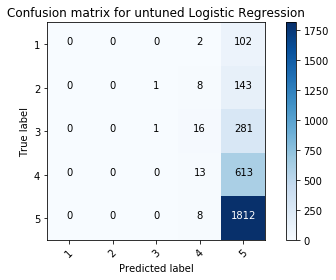

In [67]:
plt.figure()
plot_confusion_matrix(lr_cm, classes=["1","2","3","4","5"],title='Confusion matrix for untuned Logistic Regression')

In [68]:
lr_tune

,LR
count,0.619667
tf-idf,0.636333
ngram-tf-idf,0.638
char-ngram-tf-idf,0.628667


Confusion matrix, without normalization
[[   9    3    5   15   94]
 [   4    1    6   37   92]
 [   1    1   19   90  169]
 [   2    0   11  131  498]
 [   2    0   10   74 1726]]


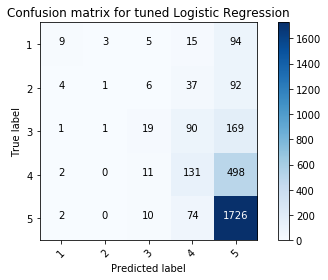

In [70]:
plt.figure()
plot_confusion_matrix(lr_tune_cm, classes=["1","2","3","4","5"],title='Confusion matrix for tuned Logistic Regression')

Only accuracy of count and char-ngram-tf-idf features has been improve by 1.6%. For other feature types, their accuracy has droped a little. 
<br>
<br>
From confusion matrix, we can find that though the error distribution becomes more distracted, the accuracy of all lables have been improved.

#### Random Forest

In [71]:
#RF
#Befor Tune up
rf,rf_cm=get_performance(amazon.loc[1:3000],train_type='normal',model_list={'RF':ensemble.RandomForestClassifier()})
#After Tune up
rf_tune,rf_tune_cm=get_performance(amazon.loc[1:3000],train_type='gridsearchcv',model_list={'RF':ensemble.RandomForestClassifier()})

('Current Model: ', 'RF', ';Current Word Vector: ', 'count')
('Current Model: ', 'RF', ';Current Word Vector: ', 'tf-idf')
('Current Model: ', 'RF', ';Current Word Vector: ', 'ngram-tf-idf')
('Current Model: ', 'RF', ';Current Word Vector: ', 'char-ngram-tf-idf')
('Current Model: ', 'RF', ';Current Word Vector: ', 'count')
('For', 'rf', ',the Grid Search End!')
('Current Model: ', 'RF', ';Current Word Vector: ', 'tf-idf')
('For', 'rf', ',the Grid Search End!')
('Current Model: ', 'RF', ';Current Word Vector: ', 'ngram-tf-idf')
('For', 'rf', ',the Grid Search End!')
('Current Model: ', 'RF', ';Current Word Vector: ', 'char-ngram-tf-idf')
('For', 'rf', ',the Grid Search End!')


In [72]:
rf

,RF
count,0.65
tf-idf,0.642222
ngram-tf-idf,0.642222
char-ngram-tf-idf,0.612222


Confusion matrix, without normalization
[[  0   0   0   4  29]
 [  1   1   0  10  28]
 [  0   0   2  15  76]
 [  1   0   4  18 139]
 [  0   0   0  42 530]]


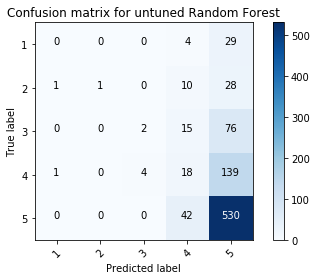

In [84]:
plt.figure()
plot_confusion_matrix(rf_cm, classes=["1","2","3","4","5"],title='Confusion matrix for untuned Random Forest')

In [75]:
rf_tune

,RF
count,0.67
tf-idf,0.656667
ngram-tf-idf,0.663333
char-ngram-tf-idf,0.664444


Confusion matrix, without normalization
[[  0   0   0   0  30]
 [  0   0   0   0  24]
 [  0   0   0   0  78]
 [  0   0   0   0 170]
 [  0   0   0   0 598]]


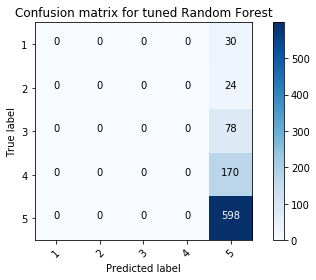

In [85]:
plt.figure()
plot_confusion_matrix(rf_tune_cm, classes=["1","2","3","4","5"],title='Confusion matrix for tuned Random Forest')

All accuracy of feature types have been improved. Count feature has been improved most by 5.4%. TF-IDF has been improved by 3.6%. Ngram-tf-idf has been improved by 1.5% and char-ngram-tf-idf has been improved by 1.3%.
<br>
<br>
From Confusion matrix, we can find that the error distribution become more concentrated.

#### SVM

In [77]:
#Befor Tune up
sv,sv_cm=get_performance(amazon.loc[1:3000],train_type='normal',model_list={'SVM':svm.SVC()})
#After Tune up
svm_tune,svm_tune_cm=get_performance(amazon.loc[1:3000],train_type='gridsearchcv',model_list={'SVM':svm.SVC()})

('Current Model: ', 'SVM', ';Current Word Vector: ', 'count')
('Current Model: ', 'SVM', ';Current Word Vector: ', 'tf-idf')
('Current Model: ', 'SVM', ';Current Word Vector: ', 'ngram-tf-idf')
('Current Model: ', 'SVM', ';Current Word Vector: ', 'char-ngram-tf-idf')
('Current Model: ', 'SVM', ';Current Word Vector: ', 'count')
('For', 'svm', ',the Grid Search End!')
('Current Model: ', 'SVM', ';Current Word Vector: ', 'tf-idf')
('For', 'svm', ',the Grid Search End!')
('Current Model: ', 'SVM', ';Current Word Vector: ', 'ngram-tf-idf')
('For', 'svm', ',the Grid Search End!')
('Current Model: ', 'SVM', ';Current Word Vector: ', 'char-ngram-tf-idf')
('For', 'svm', ',the Grid Search End!')


In [78]:
sv

,SVM
count,0.663333
tf-idf,0.662222
ngram-tf-idf,0.64
char-ngram-tf-idf,0.666667


Confusion matrix, without normalization
[[  0   0   0   0  29]
 [  0   0   0   0  26]
 [  0   0   0   0  59]
 [  0   0   0   0 186]
 [  0   0   0   0 600]]


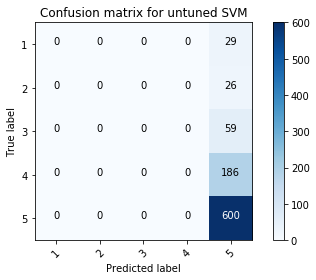

In [79]:
plt.figure()
plot_confusion_matrix(sv_cm, classes=["1","2","3","4","5"],title='Confusion matrix for untuned SVM')

In [80]:
svm_tune

,SVM
count,0.644444
tf-idf,0.656667
ngram-tf-idf,0.658889
char-ngram-tf-idf,0.658889


Confusion matrix, without normalization
[[  0   0   0   0  34]
 [  0   0   0   0  32]
 [  0   0   0   0  67]
 [  0   0   0   0 174]
 [  0   0   0   0 593]]


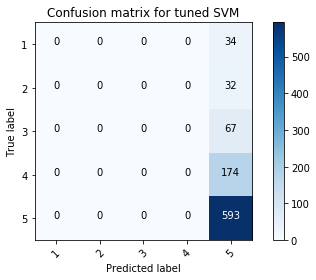

In [81]:
plt.figure()
plot_confusion_matrix(svm_tune_cm, classes=["1","2","3","4","5"],title='Confusion matrix for tuned SVM')

There are some difference in different feature types. Count feature has been droped most by 3.0%. However, TF-IDF has been improved by 1.8%. Ngram-tf-idf has been improved by 1.3% and char-ngram-tf-idf has been improved by 0.3%.
<br>
<br>
From Confusion matrix, we can find that tuning does not alway have positive effects on SVM model.

#### Naive Bayes

In [82]:
#NB
#Befor Tune up
nb,nb_cm=get_performance(amazon.loc[1:3000],train_type='normal',model_list={'NB':naive_bayes.MultinomialNB()})
#After Tune up
nb_tune,nb_tune_cm=get_performance(amazon.loc[1:3000],train_type='gridsearchcv',model_list={'NB':naive_bayes.MultinomialNB()})

('Current Model: ', 'NB', ';Current Word Vector: ', 'count')
('Current Model: ', 'NB', ';Current Word Vector: ', 'tf-idf')
('Current Model: ', 'NB', ';Current Word Vector: ', 'ngram-tf-idf')
('Current Model: ', 'NB', ';Current Word Vector: ', 'char-ngram-tf-idf')
('Current Model: ', 'NB', ';Current Word Vector: ', 'count')
('For', 'nb', ',the Grid Search End!')
('Current Model: ', 'NB', ';Current Word Vector: ', 'tf-idf')
('For', 'nb', ',the Grid Search End!')
('Current Model: ', 'NB', ';Current Word Vector: ', 'ngram-tf-idf')
('For', 'nb', ',the Grid Search End!')
('Current Model: ', 'NB', ';Current Word Vector: ', 'char-ngram-tf-idf')
('For', 'nb', ',the Grid Search End!')


In [83]:
nb

,NB
count,0.603333
tf-idf,0.622222
ngram-tf-idf,0.66
char-ngram-tf-idf,0.681111


Confusion matrix, without normalization
[[  0   0   0   0  24]
 [  0   0   0   0  24]
 [  0   0   0   0  65]
 [  0   0   0   0 174]
 [  0   0   0   0 613]]


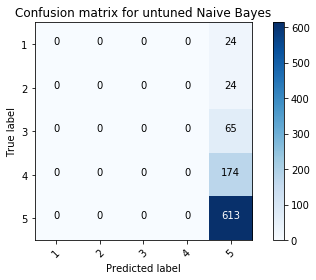

In [86]:
plt.figure()
plot_confusion_matrix(nb_cm, classes=["1","2","3","4","5"],title='Confusion matrix for untuned Naive Bayes')

In [87]:
nb_tune

,NB
count,0.641111
tf-idf,0.64
ngram-tf-idf,0.65
char-ngram-tf-idf,0.613333


Confusion matrix, without normalization
[[  0   0   0   0  37]
 [  0   0   0   0  31]
 [  0   0   0   0  79]
 [  0   0   0   0 201]
 [  0   0   0   0 552]]


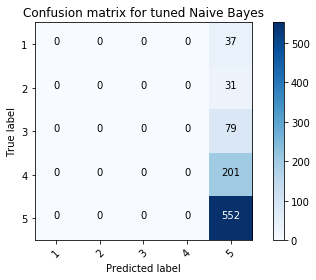

In [88]:
plt.figure()
plot_confusion_matrix(nb_tune_cm, classes=["1","2","3","4","5"],title='Confusion matrix for tuned Naive Bayes')

Char-ngram-tf-idf has improved most by 2.2% and count improved a little by 0.8%. For tf-idf and ngram-tf-idf, their accuray droped a little.
<br>
<br>
From Confusion matrix, we can find that tuning does not alway have positive effects on Naive Bayes.

#### Gradient Boosting Decision Tree

In [14]:
#GBDT
#Befor Tune up
gbm,gbm_cm=get_performance(amazon.loc[1:3000],train_type='normal',model_list={'GBM':ensemble.GradientBoostingClassifier()})
#After Tune up
gbm_tune,gbm_tune_cm=get_performance(amazon.loc[1:3000],train_type='gridsearchcv',model_list={'GBM':ensemble.GradientBoostingClassifier()})

('Current Model: ', 'GBM', ';Current Word Vector: ', 'count')
('Current Model: ', 'GBM', ';Current Word Vector: ', 'tf-idf')
('Current Model: ', 'GBM', ';Current Word Vector: ', 'ngram-tf-idf')
('Current Model: ', 'GBM', ';Current Word Vector: ', 'char-ngram-tf-idf')
('Current Model: ', 'GBM', ';Current Word Vector: ', 'count')
('For', 'gbm', ',the Grid Search End!')
('Current Model: ', 'GBM', ';Current Word Vector: ', 'tf-idf')
('For', 'gbm', ',the Grid Search End!')
('Current Model: ', 'GBM', ';Current Word Vector: ', 'ngram-tf-idf')
('For', 'gbm', ',the Grid Search End!')
('Current Model: ', 'GBM', ';Current Word Vector: ', 'char-ngram-tf-idf')
('For', 'gbm', ',the Grid Search End!')


In [15]:
gbm

,GBM
count,0.661111
tf-idf,0.644444
ngram-tf-idf,0.646667
char-ngram-tf-idf,0.651111


Confusion matrix, without normalization
[[  1   2   1   4  27]
 [  0   0   3   4  19]
 [  0   0   3  15  53]
 [  1   0   4  24 155]
 [  2   1   2  21 558]]


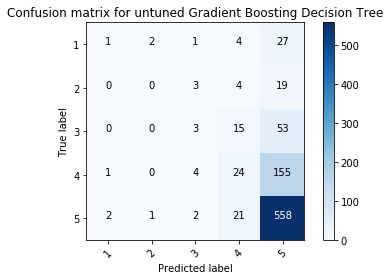

In [16]:
plt.figure()
plot_confusion_matrix(gbm_cm, classes=["1","2","3","4","5"],title='Confusion matrix for untuned Gradient Boosting Decision Tree')

In [17]:
gbm_tune

,GBM
count,0.68
tf-idf,0.666667
ngram-tf-idf,0.65
char-ngram-tf-idf,0.668889


Confusion matrix, without normalization
[[  0   0   1   6  30]
 [  0   0   0   2  22]
 [  0   0   3  17  61]
 [  0   0   1  16 144]
 [  0   0   1  13 583]]


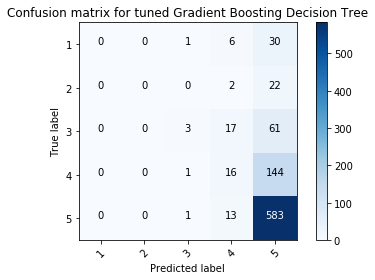

In [18]:
plt.figure()
plot_confusion_matrix(gbm_tune_cm, classes=["1","2","3","4","5"],title='Confusion matrix for tuned Gradient Boosting Decision Tree')

Char-ngram-tf-idf has decreased most by 1.9% and count decreased a little by 1.0%. For tf-idf and ngram-tf-idf, their accuray improved by 0.8% and 0.9% each.
<br>
<br>
From Confusion matrix, we can find that tuning does not alway have positive effects on GBDT.

### Other Exploration:

<font size="3">Metric y before is the original users' rates.
In fact, the classifier works not goot.

Hypothesis: 
1. There are few words in reviews.
2. There are too many kinds of rates. The conception of rate is different from user to user.

Considering these, we redefine y into good, medium and bad.</font>

In [23]:
##Redefinition of y metric for Logisitic Regression

amazon['new_flag']=amazon['overall']
amazon['new_flag'][amazon['new_flag']<3]=3
amazon['new_flag'].value_counts()
##pre
pre,pre_cm=get_performance(amazon.loc[1:10000],model_list={'LR':linear_model.LogisticRegression()},train_type='cv',flag='overall')

##after
aft,aft_cm=get_performance(amazon.loc[1:10000],model_list={'LR':linear_model.LogisticRegression()},train_type='cv',flag='new_flag')


('Current Model: ', 'LR', ';Current Word Vector: ', 'count')
('The result of Cross Validation:', array([0.5994006 , 0.56771614, 0.554     , 0.5907954 , 0.58958959]))
('Current Model: ', 'LR', ';Current Word Vector: ', 'tf-idf')
('The result of Cross Validation:', array([0.61788212, 0.62118941, 0.6135    , 0.62981491, 0.63513514]))
('Current Model: ', 'LR', ';Current Word Vector: ', 'ngram-tf-idf')
('The result of Cross Validation:', array([0.62087912, 0.62168916, 0.612     , 0.62181091, 0.63463463]))
('Current Model: ', 'LR', ';Current Word Vector: ', 'char-ngram-tf-idf')
('The result of Cross Validation:', array([0.6023976 , 0.6031984 , 0.603     , 0.60330165, 0.6016016 ]))
('Current Model: ', 'LR', ';Current Word Vector: ', 'count')
('The result of Cross Validation:', array([0.64317841, 0.61269365, 0.6165    , 0.64532266, 0.63481741]))
('Current Model: ', 'LR', ';Current Word Vector: ', 'tf-idf')
('The result of Cross Validation:', array([0.67016492, 0.67466267, 0.6645    , 0.6833416

In [24]:
pre

,LR
count,0.5803
tf-idf,0.623504
ngram-tf-idf,0.622203
char-ngram-tf-idf,0.6027


In [25]:
aft

,LR
count,0.630502
tf-idf,0.674802
ngram-tf-idf,0.675102
char-ngram-tf-idf,0.619099


As Logistic Regression as an example, after changing definition of y, all of scores of accuracy have improved a lot. 
Count feature has been improved by 5.0%; 
TF-IDF has been improved by 5.1%;
Ngram-tf-idf has been improved by 5.3%;
Char-ngram-tf-idf has been improved by 1.6%.
From this kind of exploration, we can find it is very important to do feature engineering.